In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

In [2]:
df = pd.read_csv("../data/train_data.csv")
df.isnull().sum()/df.shape[0]*100

Company             0.0
TypeName            0.0
Inches              0.0
ScreenResolution    0.0
Cpu                 0.0
Ram                 0.0
Memory              0.0
Gpu                 0.0
OpSys               0.0
Weight              0.0
Price               0.0
dtype: float64

In [3]:
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia GeForce GTX 1050 Ti,Linux,2.5kg,52161.120
1,Asus,Notebook,14.0,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4GB,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.5kg,14811.840
2,Dell,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics,Linux,2.2kg,14646.672
3,Lenovo,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 7500U 2.7GHz,16GB,1TB SSD,Intel HD Graphics 620,Windows 10,1.42kg,150462.720
4,Acer,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4GB,500GB HDD,Intel HD Graphics 520,Windows 10,2.4kg,23976.000


In [ ]:
# ANOVA test
def anova_test(col):
    categories = df[col].unique()
    category_data = [df[df[col] == category]["Price"] for category in categories]
    f_stat, p_value = stats.f_oneway(*category_data)
    return p_value

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    p_value = anova_test(col)
    print(f"ANOVA test for {col}: p-value = {p_value}")


ANOVA test for Company: p-value = 7.743633484227903e-35
ANOVA test for TypeName: p-value = 4.981214441712596e-118
ANOVA test for ScreenResolution: p-value = 4.327331245755387e-105
ANOVA test for Cpu: p-value = 1.9544168006428565e-174
ANOVA test for Ram: p-value = 7.402571259828944e-219
ANOVA test for Memory: p-value = 1.1100920848697286e-172
ANOVA test for Gpu: p-value = 1.3269590686336727e-168
ANOVA test for OpSys: p-value = 7.997251667688204e-26
ANOVA test for Weight: p-value = 6.473021013682175e-99


In [ ]:
def chi_squared_test(col):
    contingency_table = pd.crosstab(df[col], df["Price"])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    return p_value

for col in categorical_cols:
    p_value = chi_squared_test(col)
    print(f"Chi-squared test for {col}: p-value = {p_value}")

Chi-squared test for Company: p-value = 1.0
Chi-squared test for TypeName: p-value = 2.9112331985702344e-11
Chi-squared test for ScreenResolution: p-value = 9.251759356221369e-06
Chi-squared test for Cpu: p-value = 0.00025447401657776496
Chi-squared test for Ram: p-value = 6.714304257035364e-21
Chi-squared test for Memory: p-value = 1.0223548770247873e-42
Chi-squared test for Gpu: p-value = 2.734078863455501e-06
Chi-squared test for OpSys: p-value = 8.351209806225444e-07
Chi-squared test for Weight: p-value = 6.585618355136755e-08


In [ ]:
df.nunique()

Company              19
TypeName              6
Inches               17
ScreenResolution     39
Cpu                 111
Ram                   9
Memory               38
Gpu                 104
OpSys                 9
Weight              172
Price               728
dtype: int64

In [7]:
# Convert Weight column to float
df["Weight"] = df["Weight"].astype(str)
df["Weight"] = df["Weight"].str.replace("kg", "", regex=False).str.strip().astype(float)
df["Ram"] = df["Ram"].str.replace("GB", "", regex=False).str.strip().astype(float)

In [8]:
# Extract company (first word)
df["cpu_company"] = df["Cpu"].str.split().str[0]

# Extract CPU speed (number before GHz)
df["cpu_speed"] = df["Cpu"].str.extract(r'(\d+\.?\d*)GHz')[0].astype(float)
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,cpu_company,cpu_speed
0,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8.0,256GB SSD,Nvidia GeForce GTX 1050 Ti,Linux,2.50,52161.120,Intel,2.8
1,Asus,Notebook,14.0,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4.0,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.50,14811.840,Intel,1.1
2,Dell,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4.0,500GB HDD,Intel HD Graphics,Linux,2.20,14646.672,Intel,1.6
3,Lenovo,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 7500U 2.7GHz,16.0,1TB SSD,Intel HD Graphics 620,Windows 10,1.42,150462.720,Intel,2.7
4,Acer,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4.0,500GB HDD,Intel HD Graphics 520,Windows 10,2.40,23976.000,Intel,2.0


In [9]:
df["Price"].corr(df["cpu_speed"])

0.42070381720020905

In [10]:
def extract_storage(row, storage_type):
    # Find all capacity-type pairs (e.g. "512GB SSD", "1TB HDD")
    matches = re.findall(r'([\d.]+)\s*(TB|GB)\s*([A-Za-z ]+)', row)
    total = 0
    for size, unit, stype in matches:
        stype = stype.strip().lower()
        value = float(size)
        # convert GB -> TB
        if unit.upper() == 'GB':
            value /= 1024
        if storage_type in stype:
            total += value
    return total

# Create 4 new columns
for stype in ["Hybrid", "SSD", "HDD", "FlashStorage"]:
    df[stype] = df["Memory"].apply(lambda x: extract_storage(x, stype.lower()))

df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,cpu_company,cpu_speed,Hybrid,SSD,HDD,FlashStorage
0,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8.0,256GB SSD,Nvidia GeForce GTX 1050 Ti,Linux,2.50,52161.120,Intel,2.8,0.0,0.25,0.000000,0
1,Asus,Notebook,14.0,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4.0,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.50,14811.840,Intel,1.1,0.0,0.00,0.000000,0
2,Dell,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4.0,500GB HDD,Intel HD Graphics,Linux,2.20,14646.672,Intel,1.6,0.0,0.00,0.488281,0
3,Lenovo,2 in 1 Convertible,14.0,Touchscreen 2560x1440,Intel Core i7 7500U 2.7GHz,16.0,1TB SSD,Intel HD Graphics 620,Windows 10,1.42,150462.720,Intel,2.7,0.0,1.00,0.000000,0
4,Acer,Notebook,15.6,1366x768,Intel Core i3 6006U 2GHz,4.0,500GB HDD,Intel HD Graphics 520,Windows 10,2.40,23976.000,Intel,2.0,0.0,0.00,0.488281,0


In [11]:
df["Resolution_Height"] = df["ScreenResolution"].str.extract(r'x(\d+)').astype(float)
df["FlashStorage"] = df["FlashStorage"].astype(float)

In [12]:
df.drop(columns=["ScreenResolution", "Cpu", "Memory"], inplace=True)    
df.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price,cpu_company,cpu_speed,Hybrid,SSD,HDD,FlashStorage,Resolution_Height
0,Acer,Notebook,15.6,8.0,Nvidia GeForce GTX 1050 Ti,Linux,2.50,52161.120,Intel,2.8,0.0,0.25,0.000000,0.0,1080.0
1,Asus,Notebook,14.0,4.0,Intel HD Graphics 500,Windows 10,1.50,14811.840,Intel,1.1,0.0,0.00,0.000000,0.0,768.0
2,Dell,Notebook,15.6,4.0,Intel HD Graphics,Linux,2.20,14646.672,Intel,1.6,0.0,0.00,0.488281,0.0,768.0
3,Lenovo,2 in 1 Convertible,14.0,16.0,Intel HD Graphics 620,Windows 10,1.42,150462.720,Intel,2.7,0.0,1.00,0.000000,0.0,1440.0
4,Acer,Notebook,15.6,4.0,Intel HD Graphics 520,Windows 10,2.40,23976.000,Intel,2.0,0.0,0.00,0.488281,0.0,768.0


In [13]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    groups = [
        df[df[col] == c]["Price"].dropna()
        for c in df[col].unique()
        if df[df[col] == c]["Price"].dropna().shape[0] > 1
    ]
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        print(f"{col}: F-statistic = {f_stat:.3f}, P-value = {p_val:.3g}")
    else:
        print(f"{col}: Not enough groups for ANOVA")

Company: F-statistic = 13.325, P-value = 6.56e-35
TypeName: F-statistic = 142.429, P-value = 4.98e-118
Gpu: F-statistic = 23.865, P-value = 9.07e-166
OpSys: F-statistic = 18.190, P-value = 8e-26
cpu_company: F-statistic = 40.964, P-value = 2.24e-10


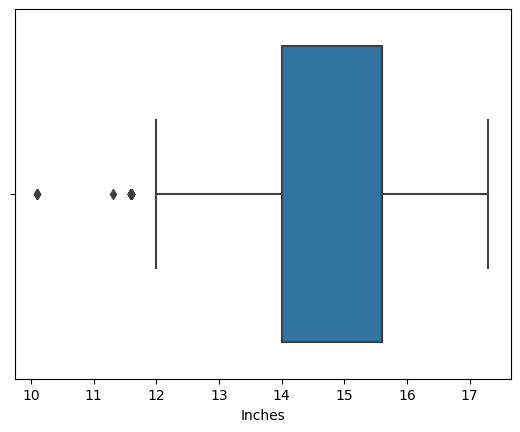

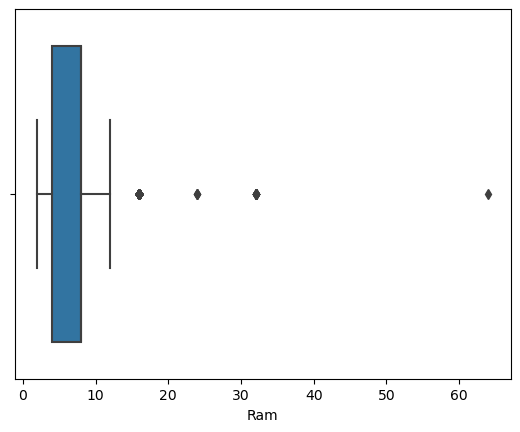

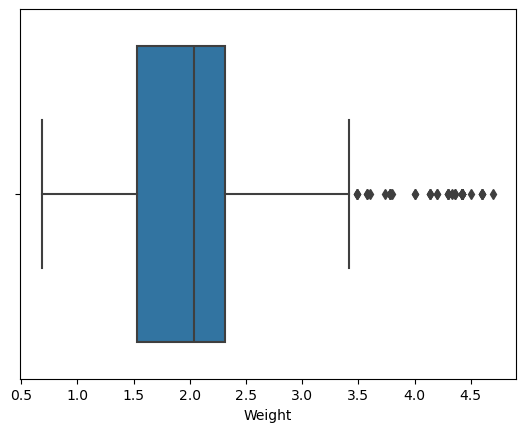

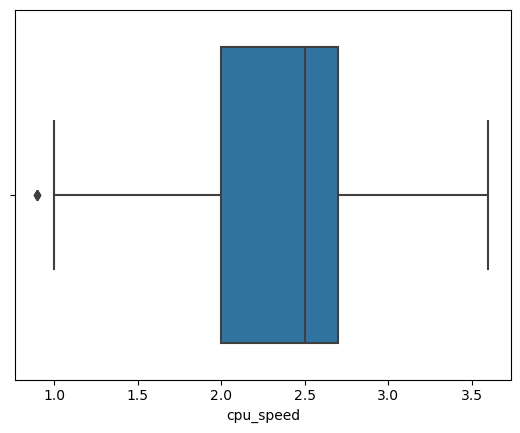

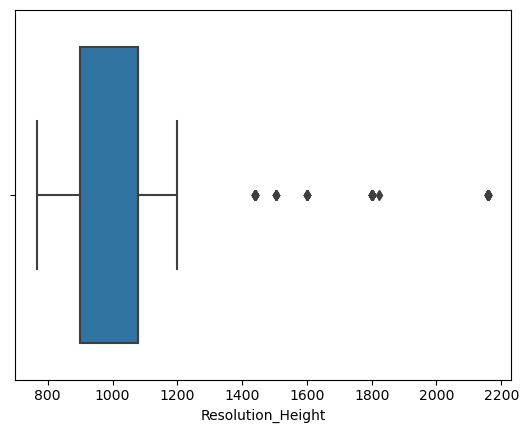

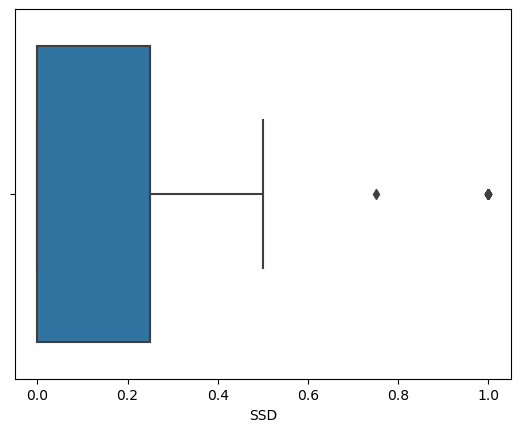

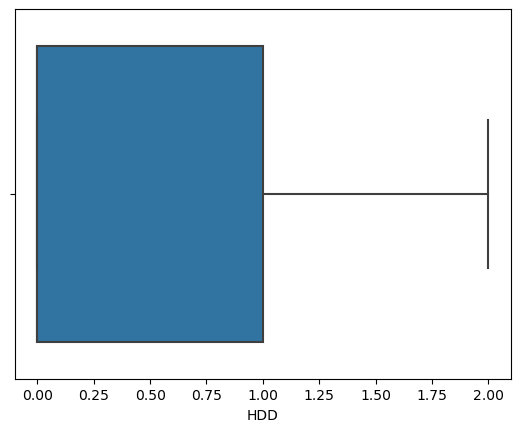

In [15]:
numeric_cols = ["Inches", "Ram", "Weight", "cpu_speed", "Resolution_Height", "SSD", "HDD"]
# numeric_cols.remove("Price")

import warnings 
warnings.filterwarnings("ignore")
for i in numeric_cols:
    sns.boxplot(data=df, x=i)
    plt.show()

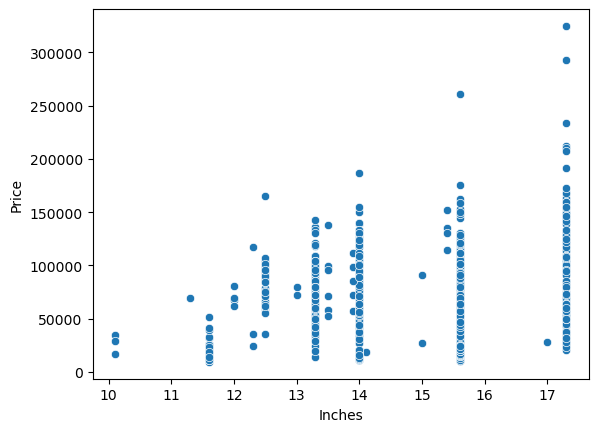

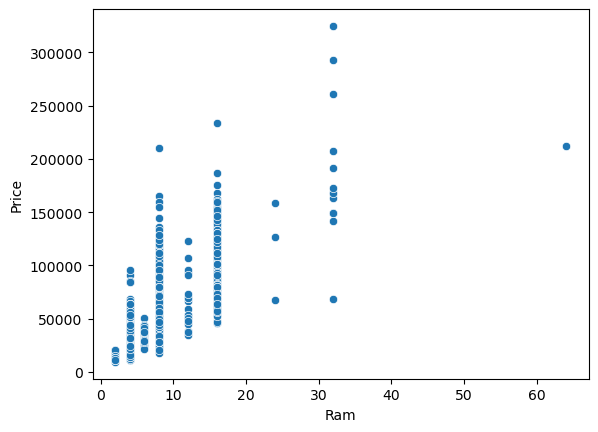

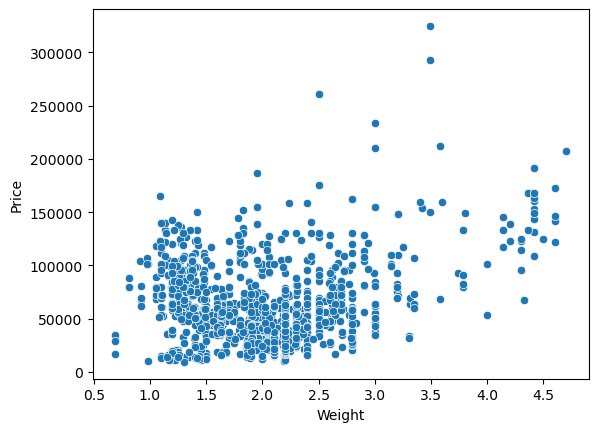

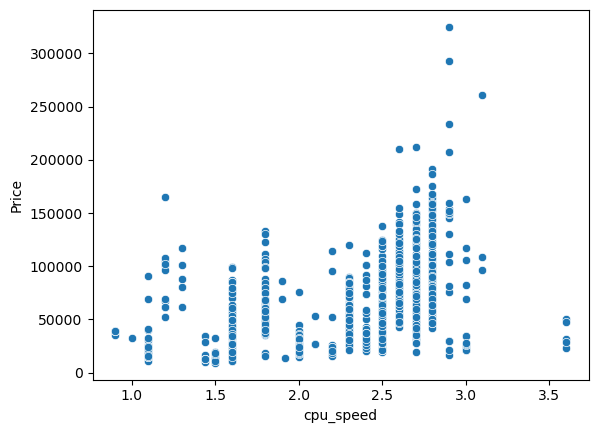

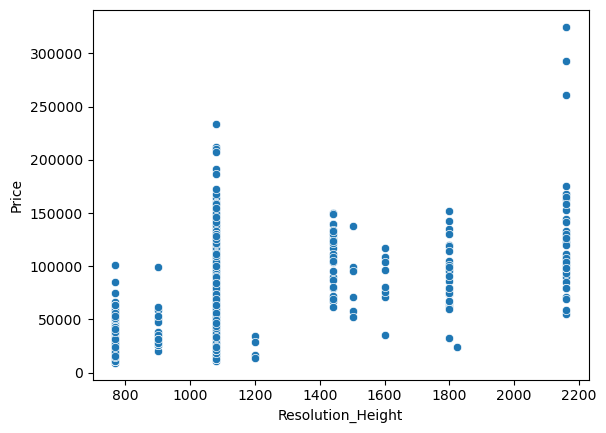

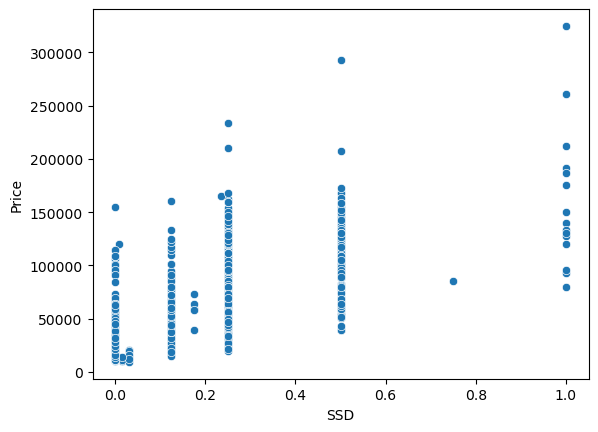

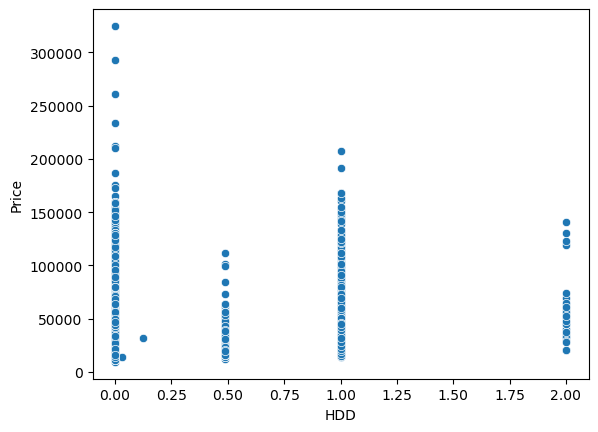

In [16]:
for i in numeric_cols:
    sns.scatterplot(data=df, x=i, y='Price')
    plt.show()

In [17]:
#Outlier remover
def whisker(col):
    Q1,Q3 = np.percentile(col,[25,75])
    iqr = Q3 - Q1
    lw = Q1 - (1.5 * iqr)
    uw = Q3 + (1.5 * iqr)
    return lw, uw

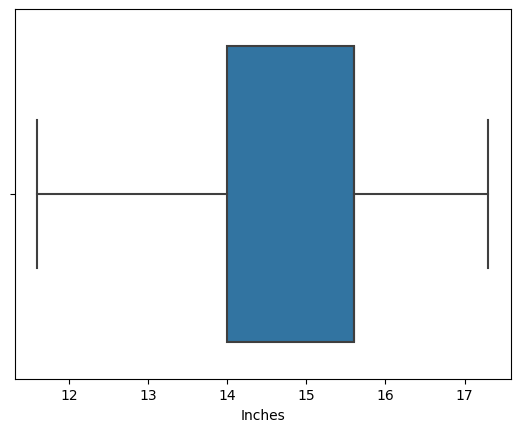

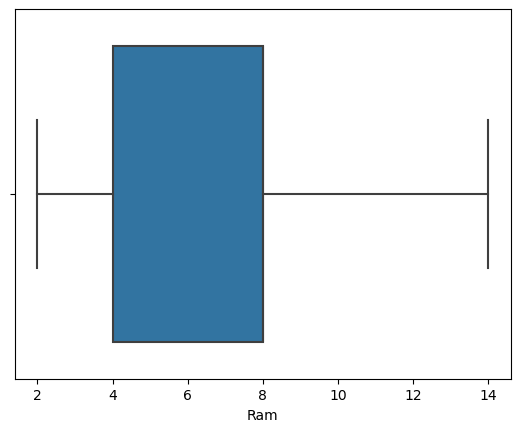

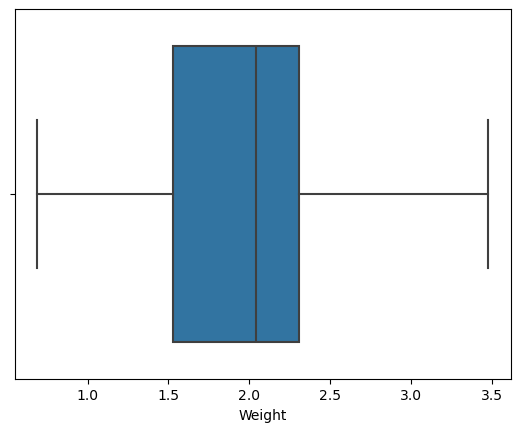

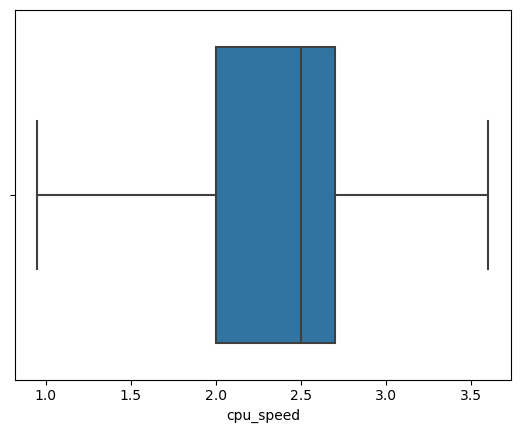

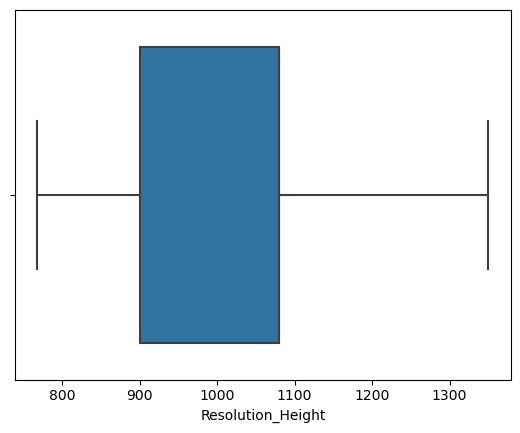

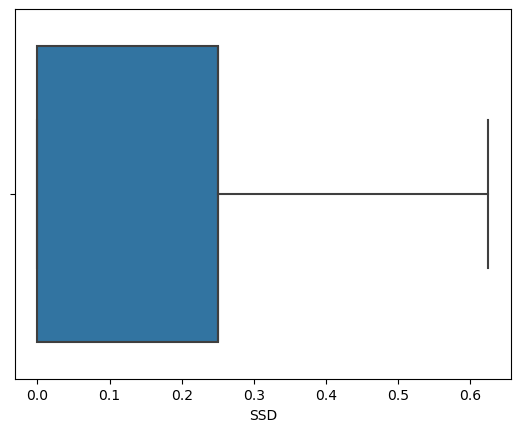

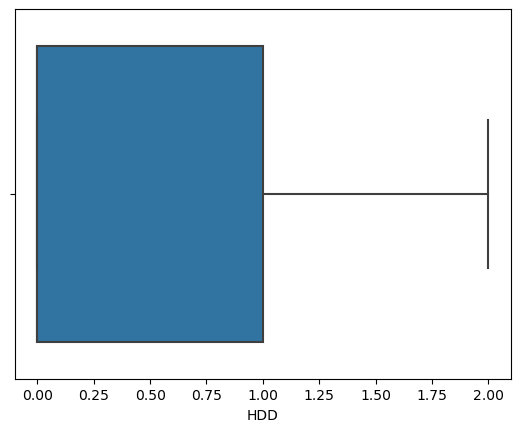

In [18]:
# numeric_cols.remove("FlashStorage")
for i in numeric_cols:
    lw,uw = whisker(df[i])
    df[i] = np.where(df[i]<lw, lw, df[i])
    df[i] = np.where(df[i]>uw, uw, df[i])
    sns.boxplot(data=df, x=i)
    plt.show()

In [19]:
# Data normalization
# numeric_cols.append("FlashStorage")
for col in numeric_cols:
            mean = df[col].mean()
            std = df[col].std()
            df[col] = (df[col] - mean) / std

In [20]:
# One-hot encoding
categorical_cols = ["Company", "TypeName", "OpSys", "cpu_company", "Gpu"]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=False, dtype=int)

df.head()

,Inches,Ram,Weight,Price,cpu_speed,Hybrid,SSD,HDD,FlashStorage,Resolution_Height,...,Gpu_Nvidia Quadro M1000M,Gpu_Nvidia Quadro M1200,Gpu_Nvidia Quadro M2000M,Gpu_Nvidia Quadro M2200,Gpu_Nvidia Quadro M2200M,Gpu_Nvidia Quadro M3000M,Gpu_Nvidia Quadro M500M,Gpu_Nvidia Quadro M520M,Gpu_Nvidia Quadro M620,Gpu_Nvidia Quadro M620M
0,0.394497,0.057559,0.812990,52161.120,0.987522,0.0,0.446074,-0.797777,0.0,0.306567,...,0,0,0,0,0,0,0,0,0,0
1,-0.747991,-1.105529,-0.890456,14811.840,-2.395336,0.0,-1.062383,-0.797777,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0
2,0.394497,-1.105529,0.301956,14646.672,-1.400378,0.0,-1.062383,0.153937,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0
3,-0.747991,1.802190,-1.026732,150462.720,0.788530,0.0,2.708759,-0.797777,0.0,1.935783,...,0,0,0,0,0,0,0,0,0,0
4,0.394497,-1.105529,0.642646,23976.000,-0.604412,0.0,-1.062383,0.153937,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.isnull().sum().sum()

0

In [22]:
df.head()

,Inches,Ram,Weight,Price,cpu_speed,Hybrid,SSD,HDD,FlashStorage,Resolution_Height,...,Gpu_Nvidia Quadro M1000M,Gpu_Nvidia Quadro M1200,Gpu_Nvidia Quadro M2000M,Gpu_Nvidia Quadro M2200,Gpu_Nvidia Quadro M2200M,Gpu_Nvidia Quadro M3000M,Gpu_Nvidia Quadro M500M,Gpu_Nvidia Quadro M520M,Gpu_Nvidia Quadro M620,Gpu_Nvidia Quadro M620M
0,0.394497,0.057559,0.812990,52161.120,0.987522,0.0,0.446074,-0.797777,0.0,0.306567,...,0,0,0,0,0,0,0,0,0,0
1,-0.747991,-1.105529,-0.890456,14811.840,-2.395336,0.0,-1.062383,-0.797777,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0
2,0.394497,-1.105529,0.301956,14646.672,-1.400378,0.0,-1.062383,0.153937,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0
3,-0.747991,1.802190,-1.026732,150462.720,0.788530,0.0,2.708759,-0.797777,0.0,1.935783,...,0,0,0,0,0,0,0,0,0,0
4,0.394497,-1.105529,0.642646,23976.000,-0.604412,0.0,-1.062383,0.153937,0.0,-1.576083,...,0,0,0,0,0,0,0,0,0,0


In [24]:
output_path = "/Users/manasvenkatasairavulapalli/Desktop/Computer Science stuff/Pure CS/Introduction to Machine Learning/Assignments/laptop_price_task-/data/cleaned_data.csv"
df.to_csv(output_path, index=False)